In [25]:
'''
Aprendendo WAFO

Henrique P P Pereira
Douglas Nemes
Franciso Sudau
'''

%matplotlib inline

import os
import pandas as pd
import wafo as wf
from  waveproc import WaveProc
import numpy as np
import pylab as pl

pathname = os.environ['HOME'] + '/Dropbox/reserva/dados/ADCP_Reef_Reserva/'

wad = pd.read_table(pathname + '20150916/ADCP_REEF_16_09_2015016.wad',
                    sep='\s*',
                    header=None,
                    index_col=False,
		            names=['bur','coun','pres','spare','analog','vxe',
                           'vyn','vzu','amp1','amp2','amp3','ampna'])


/usr/local/python/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [24]:
import wafo.definitions as wd
# wd.crossings()
# wd.waves()
wd.wave_periods()


    Wave periods (lengths) definitions and nomenclature

    Definition of wave periods (lengths)
    ------------------------------------


               <----- Direction of wave propagation

                   <-------Tu--------->
                   :                  :
                   <---Tc----->       :
                   :          :       : <------Tcc---->
       M           :      c   :       : :             :
      / \          : M   / \_ :       : c_            c
     F   \         :/ \m/    \:       :/  \          / \
    ------d--------u----------d-------u----d--------u---d-------- level v
           \      /            \     /     :\_    _/:   :\_   L
            \_   /              \_t_/      :  \t_/  :   :  \m/
              \t/                 :        :        :   :
               :                  :        <---Tt--->   :
               <--------Ttt------->        :            :
                                           <-----Td----->
    Tu   = Up crossing peri

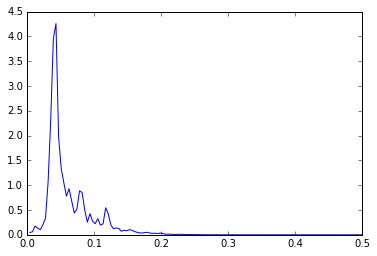

In [68]:
'''
Wave data processing waveproc.py
'''

w = WaveProc(pathname)

w.n1 = np.array(wad.pres) - wad.pres.mean()
w.n2 = wad.vxe
w.n3 = wad.vyn
w.h = wad.pres.mean() + 0.9
w.t = np.array(wad.coun)
w.dt = w.t[3] - w.t[2]
w.fs = 1/w.dt
w.nfft = 256

#data (for wafo format)
dd = np.array([w.t,w.n1,w.n2,w.n3]).T

w.timedomain()
w.freqdomain()

pl.plot(w.f, w.sn1[:,1])

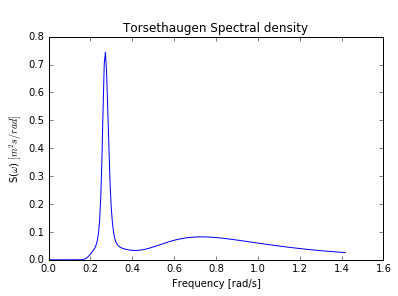

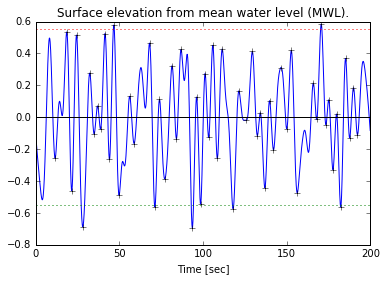

In [69]:
'''Simulation from spectrum, estimation of spectrum

Simulation of the sea surface from spectrum. The following code generates
200 seconds of data sampled with 10Hz from the Torsethaugen spectrum.
'''

import wafo.spectrum.models as wsm
from matplotlib.pyplot import *
S = wsm.Torsethaugen(Hm0=w.hm0, Tp=w.tp);
S1 = S.tospecdata()
S1.plot()

import wafo.objects as wo
xs = S1.sim(ns=2000, dt=0.1)
ts = wo.mat2timeseries(xs)
ts.plot_wave('-', nsub=1)

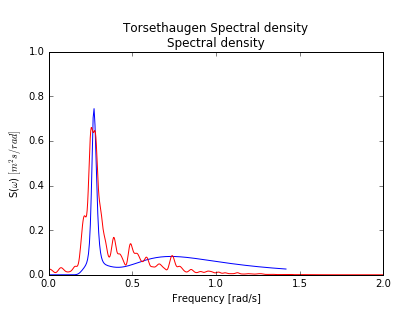

In [70]:
'''
Estimation of spectrum

A common situation is that one wants to estimate the spectrum
for wave measurements. The following code simulate 20 minutes
signal sampled at 4Hz and compare the spectral estimate with 
the original Torsethaugen spectum.

S1.args - vetor de frequencia
'''

Fs = 4;  
#xs = S1.sim(ns=fix(20 * 60 * Fs), dt=1. / Fs) 
xs = np.array([w.t, w.n1]).T
ts = wo.mat2timeseries(xs) 
Sest = ts.tospecdata(L=None)
S1.plot()
Sest.plot('r-')
axis([0, 2, 0, 1]) # This may depend on the simulation
show()

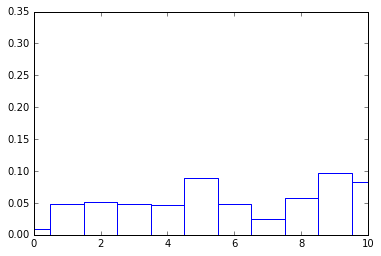

In [71]:
'''
Probability distributions of wave characteristics.

Probability distribution of wave trough period: WAFO gives the possibility
of computing the exact probability distributions for a number of 
characteristics given a spectral density. In the following example we study 
the trough period extracted from the time series and compared with the theoretical
density computed with exact spectrum, S1, and the estimated spectrum, Sest.

*esta dando erro no to_t_pdf
'''

import wafo.misc as wm
#dtyex = S1.to_t_pdf(pdef='Tt', paramt=(0, 10, 51), nit=3)
#dtyest = Sest.to_t_pdf(pdef='Tt', paramt=(0, 10, 51), nit=3)
T, index = ts.wave_periods(vh=0, pdef='d2u')
bins = wm.good_bins(T, num_bins=25, odd=True)
wm.plot_histgrm(T, bins=bins, normed=True)

#dtyex.plot()
#dtyest.plot('-.')
axis([0, 10, 0, 0.35])
show()

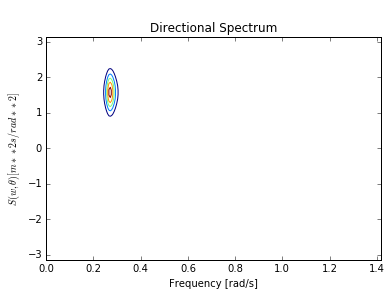

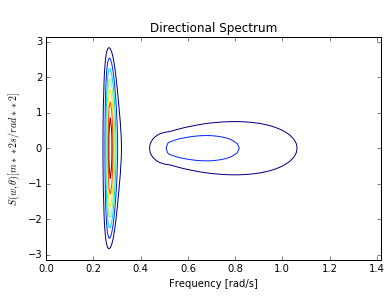

In [72]:
'''
Directional spectra
Here are a few lines of code, which produce directional
spectra with frequency independent and frequency dependent spreading.
'''

plotflag = 1
Nt = 101;   # number of angles
th0 = np.pi / 2; # primary direction of waves
Sp = 15;   # spreading parameter

D1 = wsm.Spreading(type='cos', theta0=th0, method=None) # frequency independent
D12 = wsm.Spreading(type='cos', theta0=0, method='mitsuyasu') # frequency dependent

SD1 = D1.tospecdata2d(S1)
SD12 = D12.tospecdata2d(S1)

pl.figure()
SD1.plot()

pl.figure()
SD12.plot()#linestyle='dashdot')
show()

In [73]:
'''
3D Simulation of the sea surface

The simulations show that frequency dependent spreading leads to much more irregular surface so the orientation of waves is less transparent compared to the frequency independent case.

Frequency independent spreading
'''

import wafo as wf

wf.seasim
plotflag = 1; iseed = 1;

Nx = 2 ^ 8;Ny = Nx;Nt = 1;dx = 0.5; dy = dx; dt = 0.25; fftdim = 2;
#randn('state', iseed)
Y1 = wf.seasim(SD1, Nx, Ny, Nt, dx, dy, dt, fftdim, plotflag);
wafostamp('', '(ER)')
axis('fill')
disp('Block = 6'), pause(pstate)

AttributeError: 'module' object has no attribute 'seasim'

In [74]:
'''
Section 1.4.4 Fatigue, Load cycles and Markov models

Switching Markow chain of turningpoints.

In fatigue applications the exact sample path is not important,
but only the tops and bottoms of the load, called the sequence of
turning points (TP). From the turning points one can extract load cycles,
from which damage calculations and fatigue life predictions can be performed.

The commands below computes the intensity of rainflowcycles for the Gaussian
model with spectrum S1 using the Markov approximation. The rainflow cycles
found in the simulated load signal are shown in the figure.
'''

clf()
paramu = [-6,6,61];
frfc = spec2cmat(S1, [], 'rfc', [], paramu);
pdfplot(frfc);
pl.hold('on')
tp = dat2tp(xs);
rfc = tp2rfc(tp);
plot(rfc[:, 2], rfc[:, 1], '.')
wafostamp('', '(ER)')
pl.hold('off')
disp('Block = 9'), pause(pstate)

NameError: name 'spec2cmat' is not defined

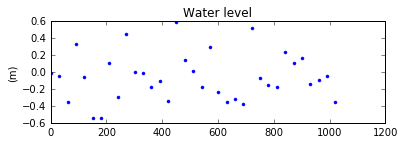

In [82]:
'''
Section 1.4.5 Extreme value statistics
'''

clf()

import wafo.data as wd
xn = dd
#xn = load('yura87.dat'); 
subplot(211) 
plot(xn[::30, 0], xn[::30, 1], '.')
title('Water level')
ylabel('(m)')

(([<matplotlib.lines.Line2D at 0x7fa009b67c90>],
   <matplotlib.text.Text at 0x7fa0036ad910>]),
 None)

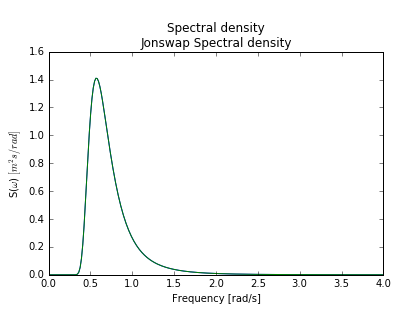

In [7]:
import numpy as np
import wafo.spectrum.models as sm
Sj = sm.Jonswap(Hm0=3)
w = np.linspace(0,4,256)
S1 = Sj.tospecdata(w)   #Make spectrum object from numerical values
S = sm.SpecData1D(Sj(w),w) # Alternatively do it manually

S.plot()
S1.plot()

In [12]:
Sj?